<a href="https://colab.research.google.com/github/sarahxu333-stack/student_performance_prediction/blob/main/Sea_Animal_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
from google.colab import drive
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import pandas
import matplotlib.pyplot as plt
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import random_split
# for splitting the data

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')
# if you need to unmount -> drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# define paths
# Top level directory for folder containing image category subfolders
# data_path = '/content/drive/MyDrive/ACM_DAS/archive'
data_path = '/content/drive/MyDrive/ACM_DAS/small_set'
saved_model_path = '/content/drive/MyDrive/ACM_DAS/model_params.pt'


In [ ]:
# TODO: create train and test transforms
from torchvision import transforms


train_transform = transforms.Compose([
   transforms.Resize(128),
   transforms.CenterCrop(128),
   transforms.RandomHorizontalFlip(),
   transforms.RandomRotation((10, 30)),
   #transforms.RandomGrayscale(),
   transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Test transforms
test_transform = transforms.Compose([
   transforms.Resize(128),
   transforms.CenterCrop(128),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [ ]:
# TODO: load dataset
train_dataset = datasets.ImageFolder(data_path, transform = train_transform)
test_dataset = datasets.ImageFolder(data_path, transform = test_transform)

In [ ]:
# Split into train and test datasets
full_dataset = datasets.ImageFolder(data_path, transform=train_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# i added a validation set to see we are not overfitting/ underfitting


In [ ]:
# update transforms if needed
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform


In [ ]:
# some info about the datasets
print("Dataset classes: ", train_dataset.dataset.classes)
print("Num train samples:", len(train_dataset))
print("Num test samples:", len(test_dataset))

Dataset classes:  ['Crabs', 'Dolphin', 'Jelly Fish', 'Sea Rays', 'Sharks']
Num train samples: 2263
Num test samples: 486


In [ ]:
# TODO: create dataloaders
train_loader = DataLoader (train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader (val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
# i fixed ur test loader's shuffle to false because you dont usually shuffle the test loaders.

Sample train images: 


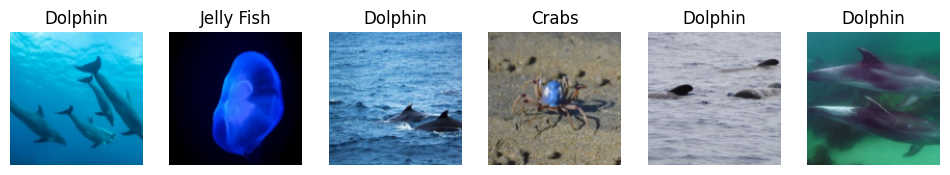

Sample test images: 


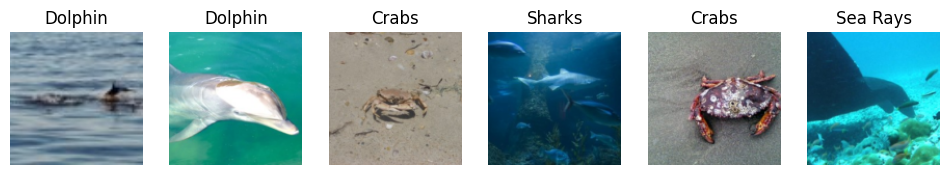

In [ ]:
# show some images
def show_sample_images(dataset, n):
  fig, ax = plt.subplots(1, n, figsize=(12,3))
  for i in range(n):
    img, label = dataset[i]
    img = (img/2) + 0.5
    ax[i].imshow(img.permute(1,2,0))
    ax[i].set_title(dataset.dataset.classes[label])
    ax[i].axis('off')
  plt.show()

print("Sample train images: ")
show_sample_images(train_dataset, 6)
print("Sample test images: ")
show_sample_images(test_dataset, 6)

In [ ]:
# define cnn model
class CNN(nn.Module):
   def __init__(self, num_classes):
       super().__init__()


       self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
       self.bn1 = nn.BatchNorm2d(16) # normalizes our conv layers
       self.pool = nn.MaxPool2d(2, 2)
       self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
       self.bn2 = nn.BatchNorm2d(32)
       self.pool2 = nn.MaxPool2d(2, 2)
       self.conv3 = nn.Conv2d(32,64,3,1, padding = 1)
       self.bn3 = nn.BatchNorm2d(64)
       self.pool3 = nn.MaxPool2d(2,2)
       self.conv4 = nn.Conv2d(64,128,3,1, padding =1)
       self.bn4 = nn.BatchNorm2d(128)
       self.pool4 = nn.MaxPool2d(2,2)


       with torch.no_grad():
         dummy_input = torch.zeros(1, 3, 128, 128)
         dummy_output = self.pool4(F.relu(self.conv4(self.pool3(F.relu(self.conv3(self.pool2(F.relu(self.conv2(self.pool(F.relu(self.conv1(dummy_input))))))))))))


       flattened_size = dummy_output.numel()

       self.dropout1 = nn.Dropout(0.5)
       self.dropout2 = nn.Dropout(0.1)

       self.fc1 = nn.Linear(flattened_size, 64)
       self.fc2 = nn.Linear(64, num_classes)


   def forward(self, x):
       x = self.pool(F.relu(self.bn1(self.conv1(x))))
       x = self.pool2(F.relu(self.bn2(self.conv2(x))))
       x = self.pool3(F.relu(self.bn3(self.conv3(x))))
       x = self.pool4(F.relu(self.bn4(self.conv4(x))))
       x = torch.flatten(x, 1)
       x = self.dropout1(x)
       x = F.relu(self.fc1(x))
       x = self.dropout2(x)
       x = self.fc2(x)
       return x

In [ ]:
# define device, model, loss function, and optimizer


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=len(train_dataset.dataset.classes))
model = model.to(device)


import torch


# number of images per class
# commented for now to accomodate for smaller subset
# class_counts = torch.tensor([497, 500, 499, 782, 497, 494, 845, 499, 500, 562,
#                           500, 482, 531, 517, 579, 478, 414, 590, 488, 483,
#                           499, 1903, 572], dtype=torch.float32)

# smaller subset for class counts
class_counts = torch.tensor([499, 782, 845, 517, 590], dtype = torch.float32)

# inverse frequency weighting
class_weights = 1.0 / class_counts


# normalize weights so mean = 1
class_weights = class_weights / class_weights.mean()


# send to device
class_weights = class_weights.to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights)


optimizer = optim.Adam(model.parameters(), lr=0.001)


# Call this function to load saved model parameters instead of retraining


def load_saved_model():
    global model
    model = CNN(num_classes=len(train_dataset.dataset.classes))
    model.load_state_dict(torch.load(saved_model_path))
    model = model.to(device)


In [ ]:
# complete training loop with per-epoch validation
for epoch in range(20):
    model.train()
    # Training
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation (this MUST be indented to the same level as training for-loop)
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f"Epoch {epoch+1} Validation Accuracy: {val_accuracy:.2f}%")

# Save the model after training
torch.save(model.state_dict(), saved_model_path)

Epoch 1 Validation Accuracy: 54.34%


Epoch 2 Validation Accuracy: 61.36%


Epoch 3 Validation Accuracy: 62.40%


Epoch 4 Validation Accuracy: 65.50%


Epoch 5 Validation Accuracy: 60.12%


Epoch 6 Validation Accuracy: 70.04%


Epoch 7 Validation Accuracy: 67.15%


Epoch 8 Validation Accuracy: 70.45%


Epoch 9 Validation Accuracy: 71.49%


Epoch 10 Validation Accuracy: 69.42%


Epoch 11 Validation Accuracy: 67.98%


Epoch 12 Validation Accuracy: 71.90%


Epoch 13 Validation Accuracy: 71.90%


Epoch 14 Validation Accuracy: 72.11%


Epoch 15 Validation Accuracy: 72.73%


Epoch 16 Validation Accuracy: 71.28%


Epoch 17 Validation Accuracy: 71.49%


Epoch 18 Validation Accuracy: 70.25%


Epoch 19 Validation Accuracy: 72.31%


Epoch 20 Validation Accuracy: 69.83%


In [ ]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    accuracy = 0
    for inputs, labels in tqdm(test_loader, leave=False):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
# 66.87% accuracy w/ smaller dataset

Test Accuracy: 70.78%


In [ ]:
# show shape of dataloader
for images, labels in train_loader:
  print("Batch shape: ", images.shape)
  print("Label shape: ", labels.shape)
  break

Batch shape:  torch.Size([32, 3, 128, 128])
Label shape:  torch.Size([32])


In [ ]:
# run model test webpage

import numpy as np
import gradio as gr

def make_prediction(input_img):
  # Apply transforms to image (and converts to tensor)
  input = test_transform(input_img).float()
  input = input.unsqueeze_(0)
  with torch.no_grad():
    # Make prediction for image
    input = input.to(device)
    model.eval()
    output =model(input)

    # Get prediction
    index = output.data.cpu().numpy().argmax()

    # Return predicted class name
    classes = train_dataset.dataset.classes
    class_name = classes[index]
    return class_name

# Load saved model so we don't need to retrain
load_saved_model()
model.eval()

demo = gr.Interface(make_prediction, gr.Image(type="pil"), "label")
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://40380e8ccda6aebb60.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
